In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from argparse import Namespace

In [2]:
opt = Namespace(
    source_img = "../images/ex1.jpg",
    mask_img = "../images/ex1_mask.png",
    target_img = "../images/first_target.jpg"
)

# Load Images

In [3]:
def preprocess_mask(mask):
    new_mask = mask.copy()
    new_mask[~ np.all(mask == [0,0,0],  axis=2)] = [255, 255, 255]
    new_mask = cv2.cvtColor(new_mask, cv2.COLOR_RGB2GRAY)
    return new_mask

In [4]:
def letterbox(img, new_shape=(640, 640), color=(0, 0, 0), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

def image_resize(img, img_size):
    """Resize image keeping aspect ratio
    Args:
        img_size (tuple): h, w
    """
    h0, w0 = img.shape[:2]  # orig hw
    r = img_size[0] / max(h0, w0)  # resize image to img_size
    if r != 1:  # always resize down, only resize up if training with augmentation
        interp = cv2.INTER_AREA if r < 1 else cv2.INTER_LINEAR
        img = cv2.resize(img, (int(w0 * r), int(h0 * r)), interpolation=interp)
    h, w = img.shape[:2] # hw_resized
    # img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized
    # letterbox
    img, ratio, (dw, dh) = letterbox(img, img_size, auto=False)
    return img

In [5]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
def plots_all(*images):
    fig, axs = plt.subplots(1, len(images),
                           figsize=(14, 10),
                           tight_layout=True)
    for ax, image in zip(axs, images):
        if image.shape[0] == 1:
            image = image.squeeze()
        ax.imshow(image, cmap="gray")
        # ax.set_axis_off()
    plt.show()

In [7]:
source_img = to_rgb(cv2.imread(opt.source_img))
target_img = to_rgb(cv2.imread(opt.target_img))
mask_img = preprocess_mask(cv2.imread(opt.mask_img))

# resize
source_img = image_resize(source_img, (224, 224))
mask_img = image_resize(mask_img, (224, 224))
target_img = image_resize(target_img, (640, 640))

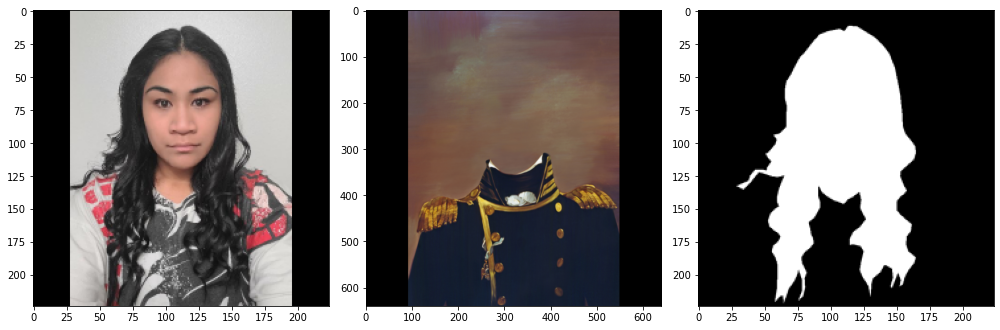

In [8]:
plots_all(source_img, target_img, mask_img)

# Get contours using mask image

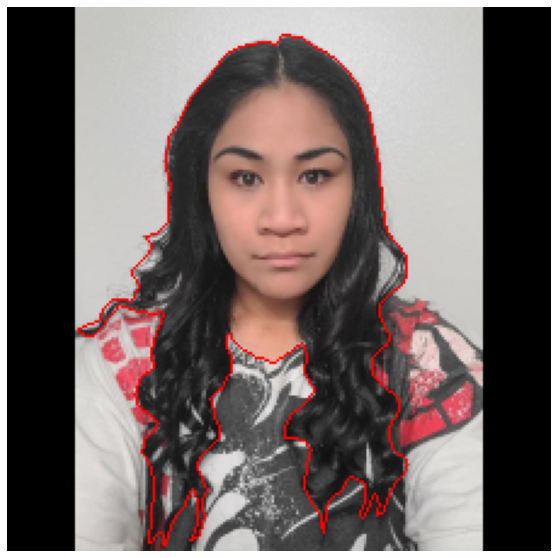

In [9]:
contours, hierarchy = cv2.findContours(image=mask_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# Sort the contours 
contours = sorted(contours, key=cv2.contourArea, reverse=True)
# Draw the contour 
img_copy = source_img.copy()
img_copy = cv2.drawContours(img_copy, contours, contourIdx=-1, 
                         color=(255, 0, 0), thickness=1)
plt.figure(figsize=(15, 10))
plt.imshow(img_copy)
plt.axis("off")
plt.show()

# Get Minimal Bounding box containing the contour and mask

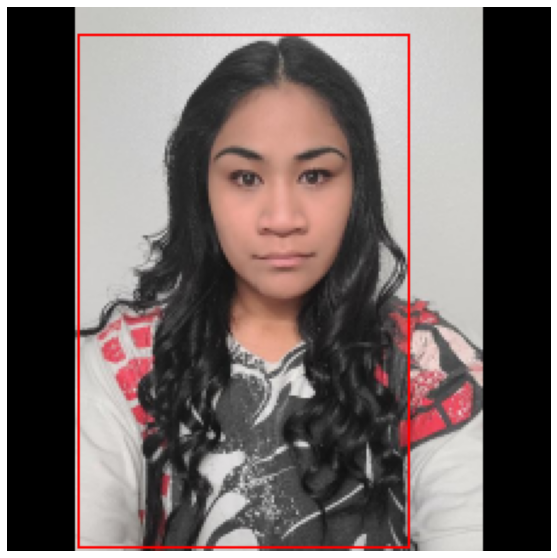

In [10]:
# The first order of the contours
c_0 = contours[0]
# Get the 4 points of the bounding rectangle
x, y, w, h = cv2.boundingRect(c_0)
# Draw a straight rectangle with the points
img_copy = source_img.copy()
img_copy = cv2.rectangle(img_copy, (x, y), (x+w, y+h), color=(255, 0, 0), thickness=1)
plt.figure(figsize=(15, 10))
plt.imshow(img_copy)
plt.axis("off")
plt.show()

With the minimal bounding box containing the mask we can crop and create a new image

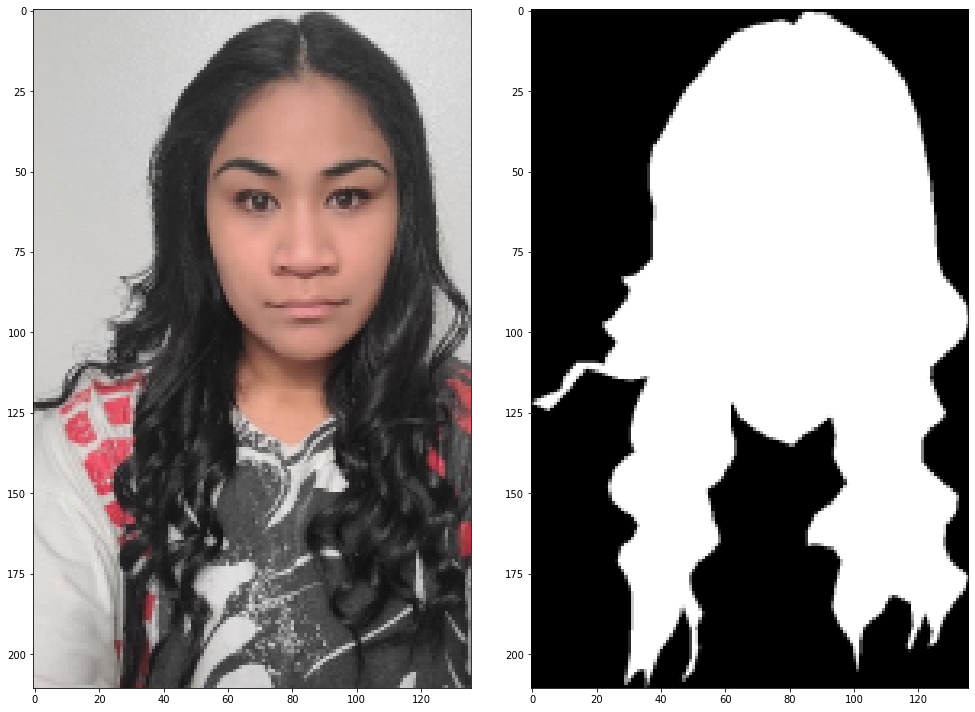

In [11]:
crop_source_img = source_img[y:y+h, x:x+w]/255.0
crop_mask_img = mask_img[y:y+h, x:x+w]/255.0
plots_all(crop_source_img, crop_mask_img)

In [12]:
crop_source_img.shape, x, y, w, h

((211, 136, 3), 29, 11, 136, 211)

# Select bounding box with x, y, w, h in the target image

Now we are going to select manually where we want to blend our image (the idea is to use a bounding box model to select the ideal one in order to automate)

In [13]:
def show_bounding_box(img, target, mask, x, y, w, h):
    img_copy = img.copy()/255.0
    img_copy = cv2.rectangle(img_copy, (x, y), (x+w, y+h), color=(255, 0, 0), thickness=1)
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1,2,1)
    plt.title(f"width: {w}, height: {h}")
    plt.imshow(img_copy)
    
    
    target_ = image_resize(target, (h, w))
    mask_ = image_resize(mask, (h, w))

    mask_canvas = np.zeros(shape=img_copy.shape[:-1])
    mask_canvas[y:y+h,x:x+w] = mask_
    input_image = np.zeros_like(img_copy)
    input_image[y:y+h,x:x+w,:] = target_
    mask_canvas = mask_canvas.reshape(*mask_canvas.shape, 1)
#     img_copy*(mask_canvas-1)*(-1)  + 
    blend = input_image*mask_canvas + img_copy*(mask_canvas-1)*(-1) 
    plt.subplot(1,2,2)
    plt.title(f"width: {w}, height: {h}")
    
    plt.imshow(blend)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


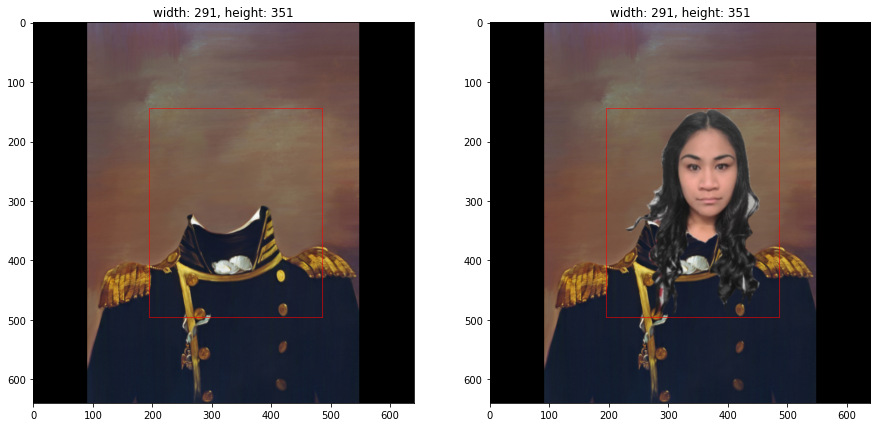

In [14]:
x_start, y_start = 195, 145
show_bounding_box(target_img, crop_source_img, crop_mask_img, 
                  x_start, y_start, w=(w + 155), h=(h + 140))

Now that we have our target bounding box what we need is to resize `crop_source_img` and `crop_mask_img` to fit in the region of the target B.B

# Resizing `crop_source_img` and `crop_mask_img`


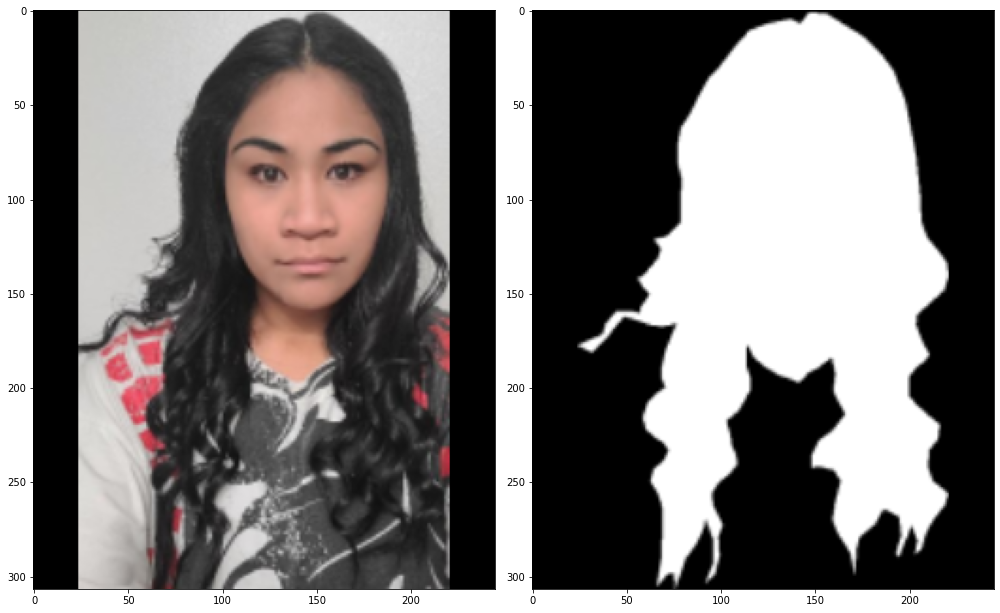

In [15]:
new_width=245
new_height=307
new_crop_source_img = image_resize(crop_source_img, (new_height, new_width))
new_crop_mask_img = image_resize(crop_mask_img, (new_height, new_width))
plots_all(new_crop_source_img, new_crop_mask_img)

In [16]:
new_crop_source_img.shape, new_crop_mask_img.shape, new_width, new_height

((307, 245, 3), (307, 245), 245, 307)

# Save new source and mask images

In [17]:
plt.imsave("../images/source_3.jpg", new_crop_source_img)
plt.imsave("../images/mask_3.jpg", new_crop_mask_img, cmap="gray")
plt.imsave("../images/target_3.jpg", target_img)

In [18]:
import json

config_target_position = {'x_start': x_start, 'y_start': y_start}
json.dump(config_target_position, open("../config/config_target_position_.json", "w"))